In [1]:
from itertools import product
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pysam
import re
import pandas as pd
import seaborn as sns


In [5]:
# obtain the path of the file
# two levels up
script_dir = os.path.dirname(os.path.realpath('__file__'))
project_dir = os.path.dirname(script_dir)

In [7]:
# define relative path for data
data_dir = os.path.join(project_dir, "data/sequencing/Expt146_Test_Injections_Amplicon")

# input paths
metadata_file = os.path.join(data_dir, "Expt146_metadata.csv")
bam_dir = os.path.join(project_dir, "bam")

# define output file
count_output_file = os.path.join(data_dir, "conversion_rates_injections.csv")

In [8]:
print(glob.glob("{}/*.bam".format(bam_dir)))

['/mnt/c/Users/prv892/Documents/GitHub/slam/data/sequencing/Expt146_Test_Injections_Amplicon/bam/Expt_146_S1.actb_aligned.umi_dedup.bam', '/mnt/c/Users/prv892/Documents/GitHub/slam/data/sequencing/Expt146_Test_Injections_Amplicon/bam/Expt_146_S10.actb_aligned.umi_dedup.bam', '/mnt/c/Users/prv892/Documents/GitHub/slam/data/sequencing/Expt146_Test_Injections_Amplicon/bam/Expt_146_S11.actb_aligned.umi_dedup.bam', '/mnt/c/Users/prv892/Documents/GitHub/slam/data/sequencing/Expt146_Test_Injections_Amplicon/bam/Expt_146_S12.actb_aligned.umi_dedup.bam', '/mnt/c/Users/prv892/Documents/GitHub/slam/data/sequencing/Expt146_Test_Injections_Amplicon/bam/Expt_146_S13.actb_aligned.umi_dedup.bam', '/mnt/c/Users/prv892/Documents/GitHub/slam/data/sequencing/Expt146_Test_Injections_Amplicon/bam/Expt_146_S14.actb_aligned.umi_dedup.bam', '/mnt/c/Users/prv892/Documents/GitHub/slam/data/sequencing/Expt146_Test_Injections_Amplicon/bam/Expt_146_S15.actb_aligned.umi_dedup.bam', '/mnt/c/Users/prv892/Documents/Git

In [11]:
def get_t_conversions(read):

    
    # populate conversions by iterating over read
    # get tuples corresponding to the (location query, location reference, reference base)
    align_tuples = read.get_aligned_pairs(matches_only=True, with_seq=True)

    # get the read query sequence
    query_seq = read.query_sequence #read.query_alignment_sequence

    t_count = 0
    tc_count = 0

    if len(query_seq) < len(align_tuples):
            print("Fail")
            print(align_tuples)
            print(len(align_tuples))
            print(query_seq)
            print(len(query_seq))
            
            return [0, 0]

    for tup in align_tuples:
        ref = tup[2].upper()
        query = query_seq[tup[0]].upper()
        
        if ref == "T":
            t_count += 1
            if query == "C":
                tc_count += 1
                
    return np.expand_dims(np.array([t_count, tc_count]), axis=0)

def get_conversions_bam(bam_filename):
    in_bam = pysam.AlignmentFile(bam_filename, "rb")
    conversions = pd.DataFrame(np.concatenate([get_t_conversions(r) for r in in_bam.fetch()], axis=0))
    conversions.columns = ['t_count', 'tc_count']
    conversions['sample_id'] = os.path.basename(bam_filename).split('.')[0]
    
    
    return conversions
    

In [9]:
bam_files = glob.glob("{}/*.bam".format(bam_dir))

In [12]:
convs_all = pd.concat([get_conversions_bam(b) for b in bam_files])

In [13]:
counts_grouped = convs_all.groupby('sample_id').agg(sum).reset_index()
counts_grouped["conversion_rate"] = counts_grouped['tc_count']/counts_grouped['t_count']

In [14]:
meta_df = pd.read_csv(metadata_file)
meta_df.head()

,sample_id,Enzyme,Injection,Injection_Poss1,Injection_Poss2,Injection_Poss3,Unnamed: 6,Injection_Poss4
0,Expt_146_S1,Negative,Subcutaneous,Subcutaneous,Subcutaneous,Subcutaneous,NaN,Subcutaneous
1,Expt_146_S10,UPRT,Intraperitoneal,Intraperitoneal,Intraperitoneal,Intraperitoneal,NaN,Intraperitoneal
2,Expt_146_S11,UPRT,Intraperitoneal,Subcutaneous,Intraperitoneal,Subcutaneous,NaN,Intraperitoneal
3,Expt_146_S12,UPRT,Subcutaneous,Intraperitoneal,Intraperitoneal,Subcutaneous,NaN,Subcutaneous
4,Expt_146_S13,Negative,Subcutaneous,Intraperitoneal,Intraperitoneal,Subcutaneous,NaN,Subcutaneous


In [15]:
counts_annot = counts_grouped.merge(meta_df, on="sample_id")


In [16]:
counts_annot.groupby(['Enzyme', 'Injection']).agg({'conversion_rate' : lambda x: np.exp(np.mean(np.log(x+0.00001)))})


conversion_rate
Enzyme   Injection                       
Negative Intraperitoneal         0.002305
         Subcutaneous            0.000316
UPRT     Intraperitoneal         0.005946
         Subcutaneous            0.003619

In [11]:
# write counts_annot to file
counts_annot.to_csv(count_output_file)

Text(0.5, 0, 'Injection Strategy')

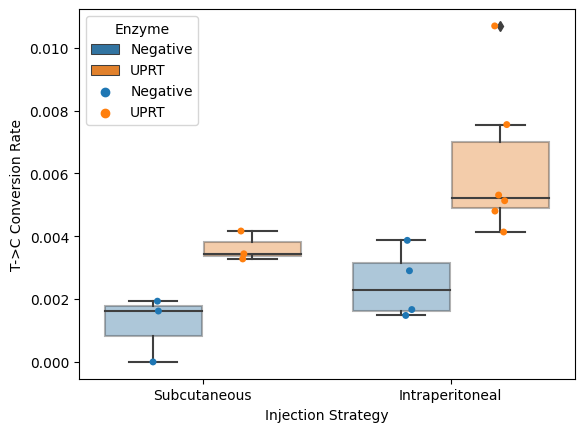

In [12]:
injection_col = "Injection"
ax = sns.boxplot(data=counts_annot, x=injection_col, y="conversion_rate",
                 hue="Enzyme", boxprops={'alpha': 0.4})
sns.stripplot(data=counts_annot, x=injection_col, y="conversion_rate",
                 hue="Enzyme", dodge=True, ax=ax)
plt.ylabel("T->C Conversion Rate")
plt.xlabel("Injection Strategy")